In [ ]:
# This part uses three models on testset to get final results

In [ ]:
!pip install timm
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.6 MB/s eta 0:00:00


Mounted at /content/drive
Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialia

Training complete in 1m 34s


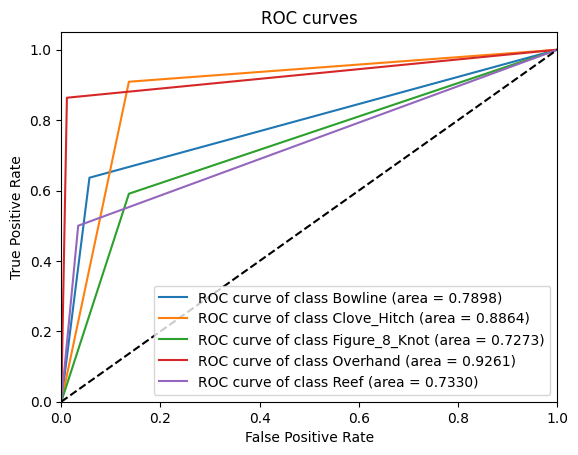

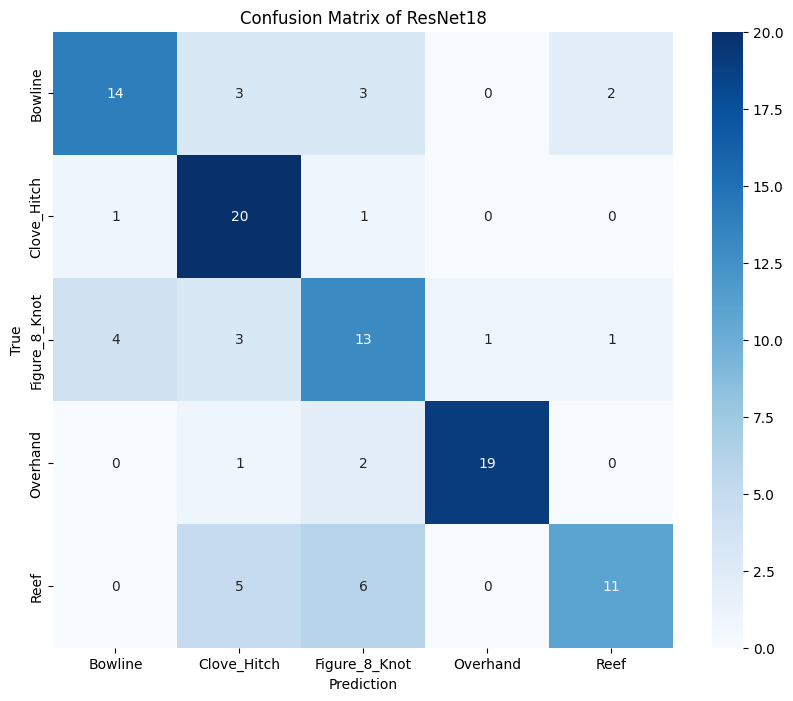

Test Accuracy: 0.7000
Test F1 Score: 0.6985


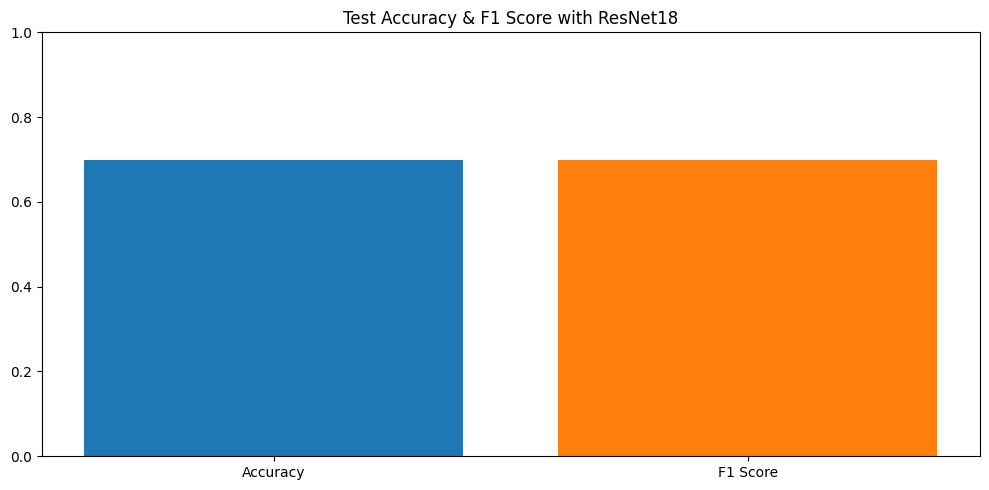

In [ ]:
# Use ResNet18 on testset


import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm
import optuna
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


class Knots_Testset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):

          images = os.listdir(os.path.join(img_dir, knot_type))
          for image in images:
            self.data.append(os.path.join(img_dir, knot_type, image))
            self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
test_dataset = Knots_Testset("/content/drive/My Drive/MSc Project/rawdata_test", transform=test_transforms)


# Create a Dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Evaluation function
def evaluate_model(model, dataloader):
    since = time.time()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return all_preds, all_labels

# Load a pretrained model(Resnet18)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Change the fc layer to 5
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('/content/drive/My Drive/MSc Project/ResNet18_weights.pth'))
model.eval()  # Set the model to evaluation mode




# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_dataloader)






# Binarize the labels
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])
test_preds_bin = label_binarize(test_preds, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names
class_names = {0: 'Bowline', 1: 'Clove_Hitch', 2: 'Figure_8_Knot', 3: 'Overhand', 4: 'Reef'}

# Plot ROC curves
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.4f})'
                                   ''.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()











# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix of ResNet18')
plt.show()



# Calculate Accuracy and F1 Score
accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
f1 = f1_score(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot Accuracy and F1 Score
plt.figure(figsize=(10, 5))

# Accuracy
plt.bar(['Accuracy'], [accuracy])
plt.ylim(0, 1)


# F1 Score
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.title('Test Accuracy & F1 Score with ResNet18')

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training complete in 0m 1s


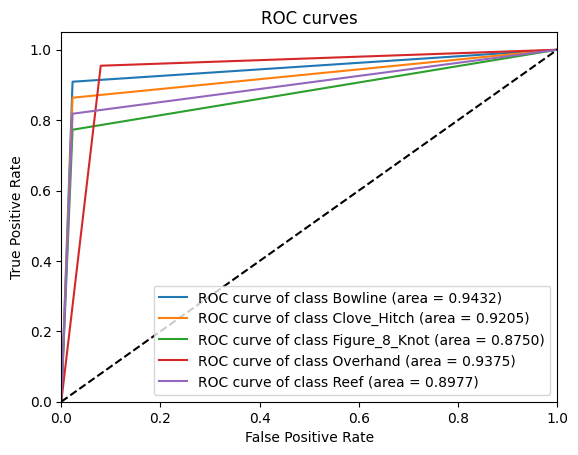

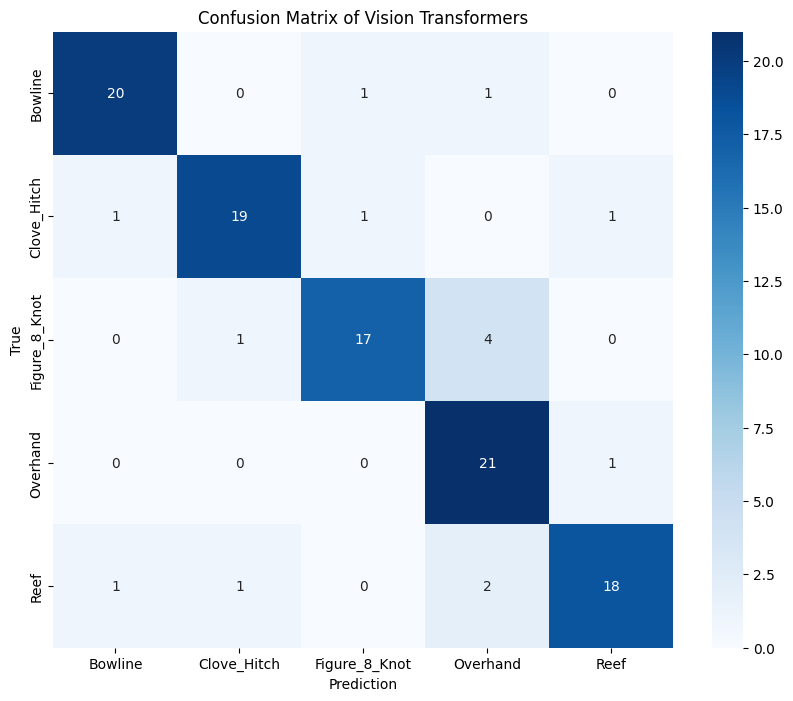

Test Accuracy: 0.8636
Test F1 Score: 0.8638


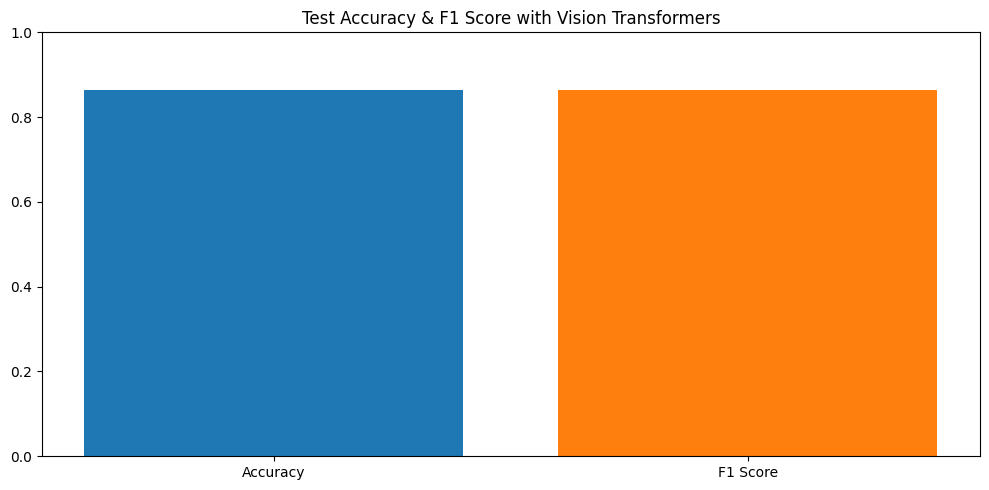

In [ ]:
# Use ViT(vit_large_patch16_224) on testset



import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm
import optuna
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


class Knots_Testset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):

          images = os.listdir(os.path.join(img_dir, knot_type))
          for image in images:
            self.data.append(os.path.join(img_dir, knot_type, image))
            self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
test_dataset = Knots_Testset("/content/drive/My Drive/MSc Project/rawdata_test", transform=test_transforms)


# Create a Dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Evaluation function
def evaluate_model(model, dataloader):
    since = time.time()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return all_preds, all_labels

# Load a pretrained model(ViT)
model = timm.create_model('vit_large_patch16_224', pretrained=True)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 5)  # Change the head layer to 5
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('/content/drive/My Drive/MSc Project/ViT_weights.pth'))
model.eval()  # Set the model to evaluation mode




# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_dataloader)






# Binarize the labels
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])
test_preds_bin = label_binarize(test_preds, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names
class_names = {0: 'Bowline', 1: 'Clove_Hitch', 2: 'Figure_8_Knot', 3: 'Overhand', 4: 'Reef'}

# Plot ROC curves
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.4f})'
                                   ''.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()











# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix of Vision Transformers')
plt.show()



# Calculate Accuracy and F1 Score
accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
f1 = f1_score(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot Accuracy and F1 Score
plt.figure(figsize=(10, 5))

# Accuracy
plt.bar(['Accuracy'], [accuracy])
plt.ylim(0, 1)

# F1 Score
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.title('Test Accuracy & F1 Score with Vision Transformers')

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training complete in 0m 1s


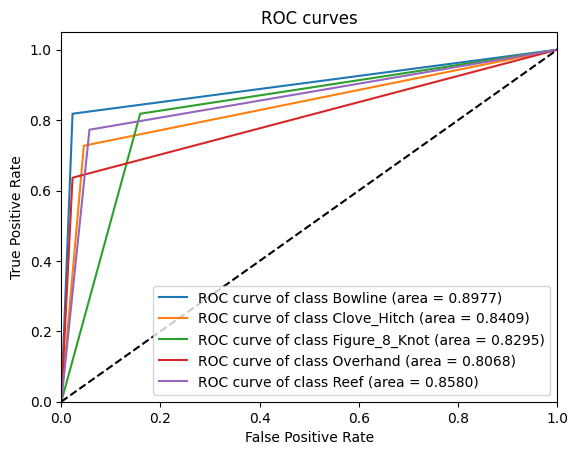

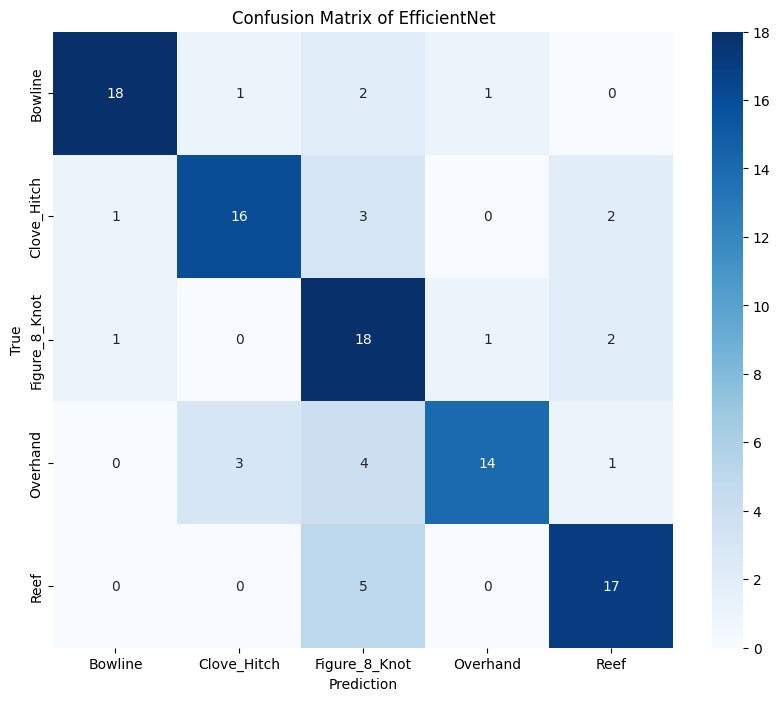

Test Accuracy: 0.7545
Test F1 Score: 0.7591


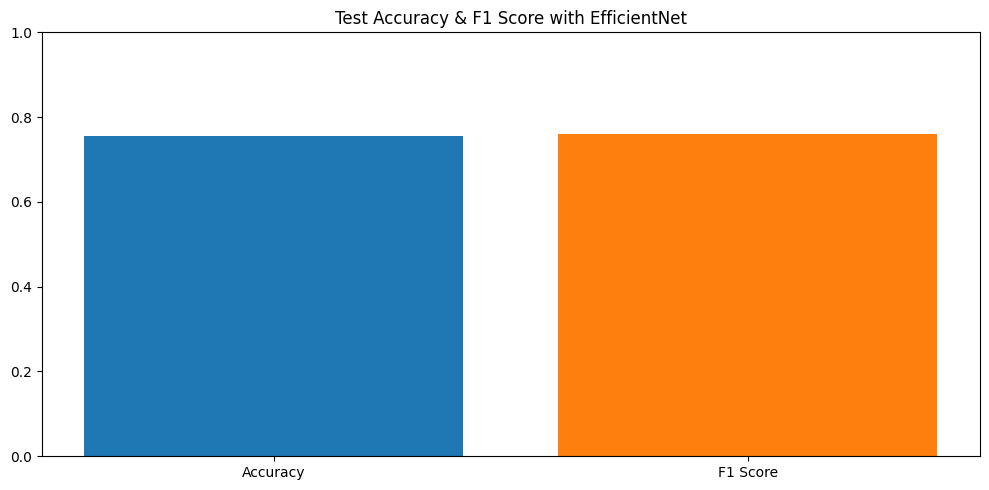

In [ ]:
# Use EfficientNet(tf_efficientnet_b5_ns) on testset



import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm
import optuna
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


class Knots_Testset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):

          images = os.listdir(os.path.join(img_dir, knot_type))
          for image in images:
            self.data.append(os.path.join(img_dir, knot_type, image))
            self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
test_dataset = Knots_Testset("/content/drive/My Drive/MSc Project/rawdata_test", transform=test_transforms)


# Create a Dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Evaluation function
def evaluate_model(model, dataloader):
    since = time.time()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return all_preds, all_labels

# Load a pretrained model(EfficientNet)
model = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5)  # Change the classifier layer to 5
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('/content/drive/My Drive/MSc Project/EfficientNet_weights.pth'))
model.eval()  # Set the model to evaluation mode




# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_dataloader)






# Binarize the labels
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])
test_preds_bin = label_binarize(test_preds, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names
class_names = {0: 'Bowline', 1: 'Clove_Hitch', 2: 'Figure_8_Knot', 3: 'Overhand', 4: 'Reef'}

# Plot ROC curves
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.4f})'
                                   ''.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()











# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix of EfficientNet')
plt.show()



# Calculate Accuracy and F1 Score
accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
f1 = f1_score(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot Accuracy and F1 Score
plt.figure(figsize=(10, 5))

# Accuracy
plt.bar(['Accuracy'], [accuracy])
plt.ylim(0, 1)

# F1 Score
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.title('Test Accuracy & F1 Score with EfficientNet')

plt.tight_layout()
plt.show()